**Цель:** исследовать дроп в продуктовой воронке между переходом в категории и добавлением в корзину.



**Summary:** исследовали дроп в продуктовой воронке между переходом в категории и добавлением в корзину путем сравнения двух групп пользователей (с конверсией и без). Значимой разницы в пользовательском пути в двух группах не наблюдается. При этом из анализа событий заметили, что пользователи с конверсией в два раза чаще пользуются поиском, а также каждый пятый пользователь с конверсией активировал промокод (тогда как пользователи без конверсии только в 4% случае активировали промокод). Также заметили, что пользователи с конверсией просматривают в два раза больше карточек товаров за первую сессию, чем пользователи без конверсии, что может говорить об изначально бОльшей мотивации пользователей с конверсией сделать покупку. Либо же пользователей без конверсии не устроил ассортимент или цены (что было заметно за счет сравнения медианы цены топ-50 просматриваемых продуктов в первую сессию каждой группой: разница незначительная, но в группе пользователей без конверсии все же медиана цены больше на 20%). Какая-либо значимая разница между пользовательскими параметрами (гео, модель телефона, платформа, версия приложения) отсутствует. Разницы в распределении по зоне доставки между двумя группами также нет.

*Можно сделать следующий вывод:* пользователи с конверсией - это более мотивированные к покупке пользователи; у каждого пятого из них есть промокод, который они активировали; такие пользователи чаще пользуются поиском; пользователи с конверсией в первое посещение просматривают продукты в среднем с меньшей ценой, чем пользователи без конверсии. Заметной же разницы в поведении и графе пути между двумя группами не наблюдается.

In [63]:
import retentioneering
import pandas as pd
import numpy as np

from google.cloud import bigquery

In [64]:
client = bigquery.Client.from_service_account_json('wuplo-client-2b0c6b6c829f.json')

In [212]:
sql = '''
    with step_2 as (
        SELECT distinct
            user_pseudo_id as user_pseudo_id_2,
            'address_input_screen' as event
        FROM `wuplo-client.analytics_272238589.events_*`, UNNEST(event_params) AS params
        where event_name in ("wup_address_input_screen")
        and (_TABLE_SUFFIX BETWEEN '20210901' and '20210927')
        and platform in ('ANDROID', 'IOS')
        and user_pseudo_id in 
        (
            SELECT distinct
                user_pseudo_id
            FROM `wuplo-client.analytics_272238589.events_*`, UNNEST(event_params) AS params
            where event_name = "wup_first_open_event"
            and (_TABLE_SUFFIX BETWEEN '20210901' and '20210927')
            and platform in ('ANDROID', 'IOS')
        )
    ),

    step_3 as (
        SELECT distinct
            user_pseudo_id as user_pseudo_id_3,
            'input_address' as event
        FROM `wuplo-client.analytics_272238589.events_*`, UNNEST(event_params) AS params
        where event_name in ("wup_input_address")
        and (_TABLE_SUFFIX BETWEEN '20210901' and '20210927')
        and platform in ('ANDROID', 'IOS')
        and params.key = "id_delivery_zone" and params.value.int_value in (15, 30, 60)
    ),

    step_5 as (
        SELECT distinct
            user_pseudo_id as user_pseudo_id_5,
            'wup_view_item_screen' as event
        FROM `wuplo-client.analytics_272238589.events_*`, UNNEST(event_params) AS params
        where event_name = "wup_view_item_screen"
        and (_TABLE_SUFFIX BETWEEN '20210901' and '20210927')
        and platform in ('ANDROID', 'IOS')
    ),

    step_6 as (
        SELECT distinct
            user_pseudo_id as user_pseudo_id_6,
            'add_to_cart_event' as event
        FROM `wuplo-client.analytics_272238589.events_*`, UNNEST(event_params) AS params
        where event_name = "add_to_cart_event"
        and (_TABLE_SUFFIX BETWEEN '20210901' and '20210927')
        and platform in ('ANDROID', 'IOS')
    )

    select
        step_5.user_pseudo_id_5 as user_id,
        step_5.event as wup_view_item_screen, 
        step_6.event as add_to_cart_event
    from step_2
    left join step_3 on step_3.user_pseudo_id_3 = step_2.user_pseudo_id_2
    left join step_5 on step_5.user_pseudo_id_5 = step_3.user_pseudo_id_3
    left join step_6 on step_5.user_pseudo_id_5 = step_6.user_pseudo_id_6
    where step_5.event is not null
    ;
'''

project_id = 'wuplo-client'

df = client.query(sql, project=project_id).to_dataframe()

In [213]:
df.head()

,user_id,wup_view_item_screen,add_to_cart_event
0,DA03C982BD074EA59E8F7F5112A719DD,wup_view_item_screen,add_to_cart_event
1,59CC405C1A0E462387B907E9E226918A,wup_view_item_screen,None
2,80EB4FC234AC44259655B6B43903AC3C,wup_view_item_screen,None
3,CD55FA67E95A4D97931CB470D941A59E,wup_view_item_screen,add_to_cart_event
4,1AAF3939C5284C6D8CF713E758927B5C,wup_view_item_screen,add_to_cart_event


In [67]:
sql = '''
    select
        user_pseudo_id,
        event_name,
        device.mobile_model_name,
        device.operating_system,
        platform,
        device.language,
        geo.country,
        app_info.version,
        min(timestamp_micros(event_timestamp)) as ts
    FROM `wuplo-client.analytics_272238589.events_*`
    where (_TABLE_SUFFIX BETWEEN '20210901' and '20210927')
    and platform in ('ANDROID', 'IOS')
    and event_name not in ("screen_view", "user_engagement", "os_update", "begin_checkout",
    "news_closeNewsScreen_event", "add_to_cart", "news_screen", "address_input_screen", "first_open",
    "input_address", "view_item_screen")
    group by user_pseudo_id, event_name, device.mobile_model_name,
        device.operating_system,
        platform,
        device.language,
        geo.country,
        app_info.version
'''

project_id = 'wuplo-client'

df_events = client.query(sql, project=project_id).to_dataframe()

In [ ]:
#     select
#         user_pseudo_id,
#         params.value.int_value as session_number,
#         count(distinct event_timestamp) as events
#     FROM `wuplo-client.analytics_272238589.events_*`, UNNEST(event_params) AS params
#     where (_TABLE_SUFFIX BETWEEN '20210901' and '20210927')
#     and platform in ('ANDROID', 'IOS')
#     and event_name in ("wup_view_item_screen")
#     and params.key = "ga_session_number"
#     and params.value.int_value = 1
#     group by user_pseudo_id, params.value.int_value

In [358]:
sql = '''
    select
        user_pseudo_id,
        avg(events) as avg_events
    from
    (
        select
            user_pseudo_id,
            params.value.int_value as session_number,
            count(distinct event_timestamp) as events
        FROM `wuplo-client.analytics_272238589.events_*`, UNNEST(event_params) AS params
        where (_TABLE_SUFFIX BETWEEN '20210901' and '20210927')
        and platform in ('ANDROID', 'IOS')
        and event_name in ("wup_view_item_screen")
        and params.key = "ga_session_number"
        group by user_pseudo_id, params.value.int_value
    )
    group by user_pseudo_id
'''

project_id = 'wuplo-client'

freq_view_items = client.query(sql, project=project_id).to_dataframe()

In [359]:
freq_view_items.sort_values(by=["avg_events"], ascending=False)

,user_pseudo_id,avg_events
876,ccad3d0a21477e66792bf1fd2b3b5b69,3146.0
1974,a28df0764210ed477769b75c5cb0fb89,2008.0
2236,A7EA8192917344FFB6C1DC67832F5CC6,1959.0
2203,722a74d3a2035579203c14bcf12d4385,1933.0
1247,b26af54551261719108e89291c164239,1904.0
...,...,...
2541,FB1D7ED1478C41BBAC132B5477C453B7,1.0
2542,e4f00b46dc7f7d4b75c61a479d080f41,1.0
2543,a0435b1afa9d7faa0a6bef7d498a45e2,1.0
2544,c7c42216fefeef98baacaf4833b672fe,1.0


In [370]:
sql = '''
    SELECT
        user_pseudo_id,
        count(distinct params.value.string_value) as count_sessions
    FROM `wuplo-client.analytics_272238589.events_*`, UNNEST(event_params) AS params
    where (_TABLE_SUFFIX BETWEEN '20210901' and '20210927')
    and platform in ('ANDROID', 'IOS')
    and event_name = "categories_list_screen"
    and params.key = "wup_session_id"
    and params.value.string_value is not null
    group by user_pseudo_id
'''

project_id = 'wuplo-client'

average_count_sessions = client.query(sql, project=project_id).to_dataframe()

In [371]:
groups_1_average_count_sessions = average_count_sessions[average_count_sessions['user_pseudo_id'].isin(users_add_to_basket)]
groups_2_average_count_sessions = average_count_sessions[average_count_sessions['user_pseudo_id'].isin(users_not_add_to_basket)]

In [374]:
print("Среднее кол-во сессий на пользователя в Группе 1: ",
      groups_1_average_count_sessions["count_sessions"].mean())

print("Среднее кол-во сессий на пользователя в Группе 2: ",
      groups_2_average_count_sessions["count_sessions"].mean())

Среднее кол-во сессий на пользователя в Группе 1:  3.715145436308927
Среднее кол-во сессий на пользователя в Группе 2:  1.705737704918033


### Отделяем пользователей с конверсией и без

In [214]:
users_add_to_basket = list(df[df["add_to_cart_event"] == "add_to_cart_event"].user_id)
users_not_add_to_basket = list(df[df["add_to_cart_event"] != "add_to_cart_event"].user_id)

In [215]:
print("Пользователей, которые добавляли в корзину: ", len(users_add_to_basket))
print("Пользователей, которые не добавляли в корзину: ", len(users_not_add_to_basket))

Пользователей, которые добавляли в корзину:  997
Пользователей, которые не добавляли в корзину:  1220


### Считаем самые кол-во просмотров карточек товаров в каждой группе 

In [360]:
groups_1_freq_view_items = freq_view_items[freq_view_items['user_pseudo_id'].isin(users_add_to_basket)]
groups_2_freq_view_items = freq_view_items[freq_view_items['user_pseudo_id'].isin(users_not_add_to_basket)]

In [361]:
print("Среднее кол-во просмотренных карточек товаров на пользователя за сессию в Группе 1: ",
      groups_1_freq_view_items["avg_events"].mean())

print("Среднее кол-во просмотренных карточек товаров на пользователя за сессию в Группе 2: ",
      groups_2_freq_view_items["avg_events"].mean())

Среднее кол-во просмотренных карточек товаров на пользователя за сессию в Группе 1:  310.5169775157995
Среднее кол-во просмотренных карточек товаров на пользователя за сессию в Группе 2:  102.78070582877957


In [263]:
groups_2_freq_view_items["events"].mean()

115.49954254345838

### Считаем распределение по зоне доставки в каждой группе 

In [322]:
sql = '''
    select
        user_pseudo_id,
        max((select value.int_value from UNNEST(event_params) where key = "id_delivery_zone")) as id_delivery_zone
    FROM `wuplo-client.analytics_272238589.events_*`, UNNEST(event_params) AS params
    where (_TABLE_SUFFIX BETWEEN '20210901' and '20210927')
    and platform in ('ANDROID', 'IOS')
    and event_name in ("wup_input_address")
    and (select value.int_value from UNNEST(event_params) where key = "ga_session_number") = 1
    group by user_pseudo_id
'''

project_id = 'wuplo-client'

deliveryzone_groups = client.query(sql, project=project_id).to_dataframe()

In [324]:
deliveryzone_groups1 = deliveryzone_groups[deliveryzone_groups['user_pseudo_id'].isin(users_add_to_basket)]
deliveryzone_groups2 = deliveryzone_groups[deliveryzone_groups['user_pseudo_id'].isin(users_not_add_to_basket)]

In [329]:
deliveryzone_groups1 = deliveryzone_groups1.groupby(["id_delivery_zone"]).agg({"user_pseudo_id": "count"}).reset_index()
deliveryzone_groups2 = deliveryzone_groups2.groupby(["id_delivery_zone"]).agg({"user_pseudo_id": "count"}).reset_index()

In [333]:
deliveryzone_groups1["share_users"] = deliveryzone_groups1["user_pseudo_id"] / deliveryzone_groups1.user_pseudo_id.sum() * 100
deliveryzone_groups2["share_users"] = deliveryzone_groups2["user_pseudo_id"] / deliveryzone_groups2.user_pseudo_id.sum() * 100

In [335]:
deliveryzone_groups2

,id_delivery_zone,user_pseudo_id,share_users
0,0,6,0.528169
1,15,107,9.419014
2,30,331,29.137324
3,60,692,60.915493


### Считаем топ просмотренных товаров в каждой группе 

In [287]:
sql = '''
    select distinct
        user_pseudo_id,
        params.value.int_value as product_id,
        (select value.int_value from UNNEST(event_params) where key = "ga_session_number") as session_number,
        (select value.double_value from unnest(event_params) where key = "current_price") as current_price
    FROM `wuplo-client.analytics_272238589.events_*`, UNNEST(event_params) AS params
    where (_TABLE_SUFFIX BETWEEN '20210901' and '20210927')
    and platform in ('ANDROID', 'IOS')
    and event_name in ("wup_view_item_screen")
    and params.key = "product_id"
    and (select value.int_value from UNNEST(event_params) where key = "ga_session_number") = 1
'''

project_id = 'wuplo-client'

products = client.query(sql, project=project_id).to_dataframe()

In [289]:
groups_1_products = products[products['user_pseudo_id'].isin(users_add_to_basket)]
groups_2_products = products[products['user_pseudo_id'].isin(users_not_add_to_basket)]

In [294]:
products1 = groups_1_products.groupby(["product_id"]).agg({"user_pseudo_id" : "count",
                                                          "current_price": "mean"
                                                          }).reset_index() \
    .sort_values(by=["user_pseudo_id"], ascending=False)

In [295]:
products2 = groups_2_products.groupby(["product_id"]).agg({"user_pseudo_id" : "count",
                                                          "current_price": "mean"
                                                          }).reset_index() \
    .sort_values(by=["user_pseudo_id"], ascending=False)

In [241]:
list_of_products = pd.read_csv("products.tsv", sep="\t", header=None)

In [243]:
list_of_products.columns = ["product_id", "name_product"]

In [296]:
products1

,product_id,user_pseudo_id,current_price
1557,6092,358,1.097542
1593,6135,356,1.097528
1211,5708,335,2.178782
24,4097,319,2.155994
1680,6237,312,1.216327
...,...,...,...
253,4496,2,3.790000
1804,6416,1,6.990000
1618,6161,1,2.690000
248,4490,1,1.890000


In [301]:
items_top_group1 = pd.merge(products1, list_of_products, how="left", on=["product_id"])
items_top_group2 = pd.merge(products2, list_of_products, how="left", on=["product_id"])

In [342]:
print("Медианная цена топ-25 самых просматриваемых продуктов в первое посещение Группы 1 :", 
      g_prod_mean_1["current_price"].median())
print("Медианная цена топ-25 самых просматриваемых продуктов в первое посещение Группы 1 :", 
      g_prod_mean_2["current_price"].median())

Медианная цена топ-25 самых просматриваемых продуктов в первое посещение Группы 1 : 1.2843847512038578
Медианная цена топ-25 самых просматриваемых продуктов в первое посещение Группы 1 : 1.6005128205128223


### Доля пользователей по совершенным событиям

In [56]:
sql = '''
    select distinct
        user_pseudo_id,
        device.mobile_model_name,
        device.operating_system,
        platform,
        device.language,
        geo.country,
        app_info.version,
        geo.city
    FROM `wuplo-client.analytics_272238589.events_*`
    where (_TABLE_SUFFIX BETWEEN '20210901' and '20210927')
    and platform in ('ANDROID', 'IOS')
    and event_name in ("wup_first_open_event")
'''

project_id = 'wuplo-client'

groups = client.query(sql, project=project_id).to_dataframe()


In [57]:
groups_1 = groups[groups['user_pseudo_id'].isin(users_add_to_basket)]
groups_2 = groups[groups['user_pseudo_id'].isin(users_not_add_to_basket)]

In [58]:
a = groups_1.groupby(["version"]).agg({"user_pseudo_id": "count"}).reset_index() \
    .sort_values(by = ["user_pseudo_id"], ascending=False)

a["share"] = a["user_pseudo_id"] / a["user_pseudo_id"].sum() * 100
a.head(15)

,version,user_pseudo_id,share
0,1.3,580,58.174524
1,1.3.0,410,41.123370
3,1.4.0,4,0.401204
2,1.4,3,0.300903


In [59]:
b = groups_2.groupby(["version"]).agg({"user_pseudo_id": "count"}).reset_index() \
    .sort_values(by = ["user_pseudo_id"], ascending=False)

b["share"] = b["user_pseudo_id"] / b["user_pseudo_id"].sum() * 100
b.head(15)

,version,user_pseudo_id,share
0,1.3,752,61.639344
1,1.3.0,465,38.114754
3,1.4.0,2,0.163934
2,1.4,1,0.081967


In [68]:
df_group_1 = df_events[df_events['user_pseudo_id'].isin(users_add_to_basket)]
df_group_2 = df_events[df_events['user_pseudo_id'].isin(users_not_add_to_basket)]

In [69]:
len(df_group_1[df_group_1["event_name"] == "promocode_activated_event"]["user_pseudo_id"].unique())

195

In [70]:
print("Доля пользователей с активацией промокода среди пользователей Группы 1: ", \
      round(len(df_group_1[df_group_1["event_name"] == "promocode_activated_event"]) / len(df_group_1["user_pseudo_id"].unique()) * 100, 1), " %")

print("Доля пользователей с активацией промокода среди пользователей Группы 2: ", \
      round(len(df_group_2[df_group_2["event_name"] == "promocode_activated_event"]) / len(df_group_2["user_pseudo_id"].unique()) * 100, 1), " %")

Доля пользователей с активацией промокода среди пользователей Группы 1:  19.6  %
Доля пользователей с активацией промокода среди пользователей Группы 2:  4.2  %


In [265]:
print("Доля пользователей с поисковыми запросами среди пользователей Группы 1: ", \
      round(len(df_group_1[df_group_1["event_name"] == "search_request_event"]) / len(df_group_1["user_pseudo_id"].unique()) * 100, 1), " %")

print("Доля пользователей с поисковыми запросами среди пользователей Группы 2: ", \
      round(len(df_group_2[df_group_2["event_name"] == "search_request_event"]) / len(df_group_2["user_pseudo_id"].unique()) * 100, 1), " %")

Доля пользователей с поисковыми запросами среди пользователей Группы 1:  51.7  %
Доля пользователей с поисковыми запросами среди пользователей Группы 2:  27.3  %


In [71]:
group1 = df_group_1.groupby(["event_name"]).agg({"user_pseudo_id": "count"}).reset_index() \
    .sort_values(by=["user_pseudo_id"], ascending=False)

group2 = df_group_2.groupby(["event_name"]).agg({"user_pseudo_id": "count"}).reset_index() \
    .sort_values(by=["user_pseudo_id"], ascending=False)

In [72]:
events = pd.merge(group1, group2, how='outer', on=['event_name'])

In [74]:
events.loc[events["event_name"] == "promocode_activated_event"]

,event_name,user_pseudo_id_x,user_pseudo_id_y
55,promocode_activated_event,195,51.0


In [164]:
events.to_excel("view.xlsx")

### Путь пользователей

In [165]:
retentioneering.config.update({
    'user_col': 'user_pseudo_id',
    'event_col':'event_name',
    'event_time_col':'ts',
})

In [ ]:
df_group_1.rete.plot_graph(norm_type='full',
                     weight_col='user_pseudo_id',
                     thresh=0.0,
                     targets = {'add_to_cart_event':'green',
                                'lost':'red'})

In [ ]:
df_group_1 = df_group_1.loc[(df_group_1["event_name"] != "session_start") & (df_group_1["event_name"] != "firebase_campaign")]
df_group_1.rete.step_matrix(max_steps=50,
                            thresh = 0.1,
                            targets=['add_to_cart_event']
)

In [ ]:
df_group_2 = df_group_2.loc[(df_group_2["event_name"] != "session_start") & (df_group_2["event_name"] != "firebase_campaign")]
df_group_2.rete.step_matrix(max_steps=50,
                            thresh = 0.1
)

In [ ]:
df_group_2.rete.step_matrix(max_steps=25,
                    thresh = 0.1,
                   centered={'event':'wup_view_item_screen',
                   'left_gap':10,
                  'occurrence':1}
                   )

In [185]:
transitions = df_group_2.rete.get_adjacency(weight_col='user_pseudo_id', norm_type='full')

In [187]:
transitions.to_excel("transitions2.xlsx")

In [392]:
sql = '''
    with first_event_date as
    (
        SELECT
            user_pseudo_id,
            min(event_date) as min_wup_first_open_event
        FROM `wuplo-client.analytics_272238589.events_*`, UNNEST(event_params) AS params
        where (_TABLE_SUFFIX BETWEEN '20210901' and '20210927')
        and platform in ('ANDROID', 'IOS')
        and event_name = "wup_first_open_event"
        group by user_pseudo_id
    ),

    add_to_cart as (
            SELECT
            user_pseudo_id,
            min(event_date) as min_add_to_cart
        FROM `wuplo-client.analytics_272238589.events_*`, UNNEST(event_params) AS params
        where (_TABLE_SUFFIX BETWEEN '20210901' and '20210927')
        and platform in ('ANDROID', 'IOS')
        and event_name = "add_to_cart_event"
        group by user_pseudo_id
    )

    select
        first_event_date.user_pseudo_id,
        first_event_date.min_wup_first_open_event,
        add_to_cart.min_add_to_cart,
        DATE_DIFF(PARSE_DATE('%Y%m%d', add_to_cart.min_add_to_cart),  
        PARSE_DATE('%Y%m%d', first_event_date.min_wup_first_open_event), DAY) as days_diff
    from first_event_date
    left join add_to_cart on add_to_cart.user_pseudo_id = first_event_date.user_pseudo_id
    where add_to_cart.min_add_to_cart is not null
'''

project_id = 'wuplo-client'

timedelta_events = client.query(sql, project=project_id).to_dataframe()

In [394]:
timedelta_events = timedelta_events[timedelta_events['user_pseudo_id'].isin(users_add_to_basket)]

In [422]:
timedelta_events = timedelta_events.groupby(["days_diff"]).agg({"user_pseudo_id": "count"}).reset_index() \
    .sort_values(by = ["user_pseudo_id"], ascending=False)

/Users/aryzhkov/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



Text(0, 0.5, 'Users')

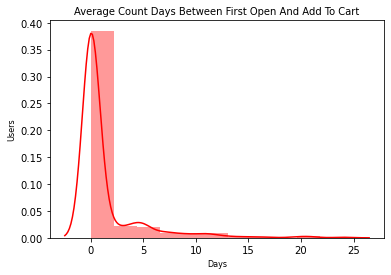

In [415]:
# timedelta_events["days_diff"].hist()
import seaborn as sns
import matplotlib.pyplot as plt

sns.distplot(timedelta_events["days_diff"], color='red', bins=11)
plt.title('Average Count Days Between First Open And Add To Cart', fontsize=10)
plt.xlabel('Days', fontsize=8)
plt.ylabel('Users', fontsize=8)

In [426]:
timedelta_events["days_diff_share"] = timedelta_events["user_pseudo_id"] / 997 * 100

In [427]:
timedelta_events

,days_diff,user_pseudo_id,days_diff_share
0,0,757,75.927783
1,1,60,6.018054
5,5,35,3.510532
4,4,29,2.908726
2,2,21,2.106319
3,3,17,1.705115
7,7,13,1.303912
11,11,10,1.003009
6,6,9,0.902708
8,8,8,0.802407


In [420]:
timedelta_events.sort_values(by = ["days_diff_share"], ascending=False)

,user_pseudo_id,min_wup_first_open_event,min_add_to_cart,days_diff,days_diff_share
115,52F110C0DC65425A816C7849053F6E86,20210903,20210927,24,2.407222
602,557d813d27c1c939594b6dd0ad888f1a,20210903,20210927,24,2.407222
780,d7070c62e0082423af6de78483ce1df1,20210904,20210925,21,2.106319
319,cab8496336efd6681b17f7a166a7819f,20210904,20210925,21,2.106319
295,8675CEF727034C6AB71C49EE2D909AF8,20210904,20210925,21,2.106319
...,...,...,...,...,...
397,85e47145e707ba306b700945abb35a13,20210927,20210927,0,0.000000
398,85eef29812d98f12791ab64780714877,20210927,20210927,0,0.000000
399,ef6dabada9043c2273daa66530840371,20210927,20210927,0,0.000000
400,b2577264af62d630eb56aa3c65b0fe72,20210927,20210927,0,0.000000


## Исследование активированных промокодов

In [82]:
import psycopg2
import pandas.io.sql as sqlio

In [83]:
sql = '''
    SELECT distinct
        user_pseudo_id,
        user_id,
        event_name,
        event_timestamp,
        (select value.string_value from unnest(user_properties) where key = "aiid") as aiid,
        (select value.int_value from unnest(event_params) where key = "type") as type
    FROM `wuplo-client.analytics_272238589.events_*`, UNNEST(event_params) AS params
    where (_TABLE_SUFFIX BETWEEN '20210901' and '20210927')
    and platform in ('ANDROID', 'IOS')
    and event_name = 'promocode_activated_event'
    ;
'''

project_id = 'wuplo-client'

promocode_users = client.query(sql, project=project_id).to_dataframe()

In [84]:
promocode_users_groups1 = promocode_users[promocode_users['user_pseudo_id'].isin(users_add_to_basket)]

In [85]:
CONN_GLOBAL = psycopg2.connect(dbname='wuplo_prod', user='sophiedata', 
                        password='DgYDq6WFr47#Etyuu@', host='db.wuplo.internal')

In [86]:
conn = CONN_GLOBAL
sql = '''
    select
        tdiscountactivations.id_user as user_id,
        tdiscountactivations.id_discount,
        tdiscounttypes.id as type_id,
        tdiscounttypes.name as type_discount,
        tdiscounts.value,
        trequests.id as id_request,
        trequests.productcost_amount,
        trequests.status,
        trequests.addstatus
    from tdiscountactivations
    left join trequests on trequests.id_discount = tdiscountactivations.id_discount
        and trequests.id_creator = tdiscountactivations.id_user
    left join tdiscounts on tdiscountactivations.id_discount = tdiscounts.id
    left join tdiscounttypes on tdiscounts.id_type = tdiscounttypes.id
    where tdiscountactivations.id_region = 2
    ;
'''
df_db = sqlio.read_sql_query(sql, conn)
conn = None

In [87]:
df_db.head()

,user_id,id_discount,type_id,type_discount,value,id_request,productcost_amount,status,addstatus
0,105453,143147,1,Скидка на корзину,0.1,178738.0,10.38,9.0,91.0
1,105453,143148,1,Скидка на корзину,0.1,178742.0,10.09,7.0,71.0
2,105458,143156,1,Скидка на корзину,0.1,178748.0,11.48,9.0,91.0
3,105458,143167,1,Скидка на корзину,0.1,178761.0,10.77,7.0,71.0
4,105458,143168,1,Скидка на корзину,0.1,178765.0,15.44,7.0,71.0


In [90]:
df_db['user_id'] = df_db['user_id'].astype(np.int64)
promocode_users_groups1['user_id'] = promocode_users_groups1['user_id'].astype(np.int64)

<ipython-input-90-1a0e31724ac8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  promocode_users_groups1['user_id'] = promocode_users_groups1['user_id'].astype(np.int64)


In [91]:
promocodes = pd.merge(promocode_users_groups1, df_db, how='left', on=["user_id"])

### Распределение пользователей по кол-ву активированных промокодов

In [92]:
promocodes_count_activation = promocodes.groupby(["user_id"]).agg({"id_discount": "count"}).reset_index()

Text(0, 0.5, 'Users')

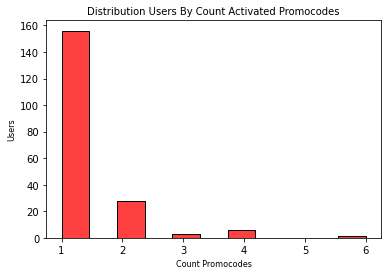

In [93]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(promocodes_count_activation["id_discount"], color='red', bins=11)
plt.title('Distribution Users By Count Activated Promocodes', fontsize=10)
plt.xlabel('Count Promocodes', fontsize=8)
plt.ylabel('Users', fontsize=8)

### Доля пользователей, которые сделали заказ из активировавших промокод

In [136]:
print("Доля пользователей с заказами: ", 
      len(promocodes[promocodes["id_request"] > 0]["user_id"].unique()) / len(promocodes["user_id"].unique()) * 100.0)
print("Кол-во пользователей с заказами: ", len(promocodes[promocodes["id_request"] > 0]["user_id"].unique()))

Доля пользователей с заказами:  37.628865979381445
Кол-во пользователей с заказами:  73


### Распределение активаций по типу промокода

In [103]:
promocodes_type_discount = promocodes.groupby(["type_discount"]).agg({"user_id": "count"}).reset_index()

Text(0, 0.5, 'Count Activation')

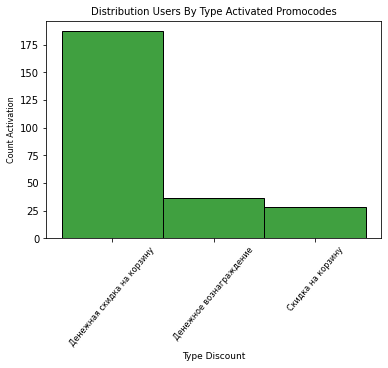

In [123]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(promocodes["type_discount"], color='green', bins=1)
plt.title('Distribution Users By Type Activated Promocodes', fontsize=10)
plt.xlabel('Type Discount', fontsize=9)
plt.xticks(rotation=50, size=8)
plt.ylabel('Count Activation', fontsize=8)

### Распределение активаций по сумме промокода

In [125]:
promocodes_value_discount = promocodes.groupby(["value"]).agg({"user_id": "count"}).reset_index()

Text(0, 0.5, 'Count Activation')

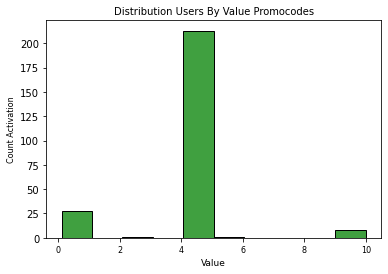

In [132]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(promocodes["value"], color='green', bins=10)
plt.title('Distribution Users By Value Promocodes', fontsize=10)
plt.xlabel('Value', fontsize=9)
plt.xticks(rotation=0, size=8)
plt.ylabel('Count Activation', fontsize=8)

In [128]:
promocodes_value_discount

,value,user_id
0,0.10,6
1,0.20,22
2,2.42,1
3,5.00,213
4,6.00,1
5,10.00,8


### Выбираем только пользователей с заказами

In [137]:
users_with_orders = promocodes[promocodes["id_request"] > 0]["user_id"].unique()

In [138]:
users_with_orders

array([106030, 106215, 105904, 106089, 106075, 105914, 106368, 106114,
       106105, 105950, 106043, 106307, 106101, 106487, 106492, 106508,
       106377, 106349, 106586, 106362, 106247, 106427, 106263, 106151,
       106712, 106734, 105957, 105888, 105977, 106198, 106444, 106645,
       106219, 106052, 106217, 106320, 106078, 105890, 106061, 106220,
       106367, 106352, 106458, 106344, 106113, 106124, 105979, 105940,
       106305, 106372, 106510, 106556, 106086, 106229, 106240, 106396,
       106380, 106287, 106282, 106270, 106145, 106140, 106133, 106713,
       106722, 106543, 105920, 106605, 106593, 106630, 106602, 106615,
       106641])

In [140]:
promocodes_orders = promocodes[promocodes['user_id'].isin(users_with_orders)]

### Распределения по типам и величине скидки промокода у таких пользователей

In [151]:
promocodes_orders_ = promocodes_orders[promocodes_orders["id_request"] > 0].reset_index()
promocodes_orders_ = promocodes_orders_[(promocodes_orders_["status"] == 9) & (promocodes_orders_["addstatus"] == 91)]

In [158]:
promocodes_orders_ = promocodes_orders_.groupby(["user_id", "type_discount", "value"]).agg({"id_request": "count"}).reset_index()

In [159]:
promocodes_orders_[promocodes_orders_["id_request"] > 1]

,user_id,type_discount,value,id_request
1,105890,Денежная скидка на корзину,5.0,2
46,106368,Денежная скидка на корзину,5.0,2


In [160]:
promocodes_orders_type_discount = promocodes_orders_.groupby(["type_discount"]).agg({"user_id": "count"}).reset_index()

In [161]:
promocodes_orders_type_discount

,type_discount,user_id
0,Денежная скидка на корзину,55
1,Скидка на корзину,15


In [162]:
promocodes_orders_value_discount = promocodes_orders_.groupby(["value"]).agg({"user_id": "count"}).reset_index()

In [163]:
promocodes_orders_value_discount

,value,user_id
0,0.1,2
1,0.2,13
2,5.0,51
3,10.0,4


### Откуда чаще кладут товары: карточка товара или каталог?

In [259]:
sql = '''
    SELECT distinct
        user_pseudo_id,
        event_name,
        event_timestamp,
        (select value.string_value from unnest(event_params) where key = "source") as source
    FROM `wuplo-client.analytics_272238589.events_*`, UNNEST(event_params) AS params
    where (_TABLE_SUFFIX BETWEEN '20210901' and '20210927')
    and platform in ('ANDROID', 'IOS')
    and event_name = 'add_to_cart_event'
    ;
'''

project_id = 'wuplo-client'

add_to_cart_source = client.query(sql, project=project_id).to_dataframe()

In [243]:
add_to_cart_source = add_to_cart_source[add_to_cart_source['user_pseudo_id'].isin(users_add_to_basket)]

In [236]:
add_to_cart_source_df = add_to_cart_source.groupby(["source"]).agg({"user_pseudo_id": "count"}).reset_index()

In [237]:
add_to_cart_source_df["share_users"] = add_to_cart_source_df["user_pseudo_id"] / add_to_cart_source_df["user_pseudo_id"].sum() * 100.0



In [238]:
add_to_cart_source_df

,source,user_pseudo_id,share_users
0,banner,5,0.045994
1,cart,320,2.943611
2,cart/detail,9,0.082789
3,catalog,8165,75.108086
4,catalog/detail,958,8.812437
5,favorites,197,1.812161
6,favorites/detail,2,0.018398
7,recommend,198,1.821360
8,recommend/detail,19,0.174777
9,search/keyboard,808,7.432619


In [254]:
add_to_cart_source = add_to_cart_source[add_to_cart_source['user_pseudo_id'].isin(users_with_orders2)]

In [255]:
add_to_cart_source.head()

,user_pseudo_id,event_name,event_timestamp,source
18,33FB2E396C2B45C2B14F6A54259B450F,add_to_cart_event,1631404523851024,catalog
19,33FB2E396C2B45C2B14F6A54259B450F,add_to_cart_event,1631404537981000,catalog
26,75DB5E2377EF457AA5C5609B11995A0B,add_to_cart_event,1631471217910011,catalog/detail
27,75DB5E2377EF457AA5C5609B11995A0B,add_to_cart_event,1631471407758033,catalog
28,75DB5E2377EF457AA5C5609B11995A0B,add_to_cart_event,1631471443086027,catalog


In [228]:
add_to_cart_source_df_order = add_to_cart_source.groupby(["source"]).agg({"user_pseudo_id": "count"}).reset_index()

In [230]:
add_to_cart_source_df_order["share_users"] = add_to_cart_source_df_order["user_pseudo_id"] / add_to_cart_source_df_order["user_pseudo_id"].sum() * 100.0



In [231]:
add_to_cart_source_df_order.head()

,source,user_pseudo_id,share_users
0,banner,5,0.090269
1,cart,138,2.491424
2,cart/detail,3,0.054161
3,catalog,4156,75.031594
4,catalog/detail,407,7.347897


In [264]:
sql = '''
    SELECT distinct
        user_pseudo_id,
        event_name,
        event_timestamp,
        (select value.string_value from unnest(event_params) where key = "source") as source
    FROM `wuplo-client.analytics_272238589.events_*`, UNNEST(event_params) AS params
    where (_TABLE_SUFFIX BETWEEN '20210901' and '20210927')
    and platform in ('ANDROID', 'IOS')
    and event_name = 'add_to_cart_event'
    and user_pseudo_id in
    (
        SELECT distinct
            user_pseudo_id
        FROM `wuplo-client.analytics_272238589.events_*`, UNNEST(event_params) AS params
        where (_TABLE_SUFFIX BETWEEN '20210901' and '20210927')
        and platform in ('ANDROID', 'IOS')
        and event_name = 'order_send_success_event'
        and user_pseudo_id in
        (
            with step_2 as (
                SELECT distinct
                    user_pseudo_id as user_pseudo_id_2,
                    'address_input_screen' as event
                FROM `wuplo-client.analytics_272238589.events_*`, UNNEST(event_params) AS params
                where event_name in ("wup_address_input_screen")
                and (_TABLE_SUFFIX BETWEEN '20210901' and '20210927')
                and platform in ('ANDROID', 'IOS')
                and user_pseudo_id in 
                (
                    SELECT distinct
                        user_pseudo_id
                    FROM `wuplo-client.analytics_272238589.events_*`, UNNEST(event_params) AS params
                    where event_name = "wup_first_open_event"
                    and (_TABLE_SUFFIX BETWEEN '20210901' and '20210927')
                    and platform in ('ANDROID', 'IOS')
                )
            ),

            step_3 as (
                SELECT distinct
                    user_pseudo_id as user_pseudo_id_3,
                    'input_address' as event
                FROM `wuplo-client.analytics_272238589.events_*`, UNNEST(event_params) AS params
                where event_name in ("wup_input_address")
                and (_TABLE_SUFFIX BETWEEN '20210901' and '20210927')
                and platform in ('ANDROID', 'IOS')
                and params.key = "id_delivery_zone" and params.value.int_value in (15, 30, 60)
            ),

            step_5 as (
                SELECT distinct
                    user_pseudo_id as user_pseudo_id_5,
                    'wup_view_item_screen' as event
                FROM `wuplo-client.analytics_272238589.events_*`, UNNEST(event_params) AS params
                where event_name = "wup_view_item_screen"
                and (_TABLE_SUFFIX BETWEEN '20210901' and '20210927')
                and platform in ('ANDROID', 'IOS')
            ),

            step_6 as (
                SELECT distinct
                    user_pseudo_id as user_pseudo_id_6,
                    'add_to_cart_event' as event
                FROM `wuplo-client.analytics_272238589.events_*`, UNNEST(event_params) AS params
                where event_name = "add_to_cart_event"
                and (_TABLE_SUFFIX BETWEEN '20210901' and '20210927')
                and platform in ('ANDROID', 'IOS')
            )

            select distinct
                step_5.user_pseudo_id_5
            from step_2
            left join step_3 on step_3.user_pseudo_id_3 = step_2.user_pseudo_id_2
            left join step_5 on step_5.user_pseudo_id_5 = step_3.user_pseudo_id_3
            left join step_6 on step_5.user_pseudo_id_5 = step_6.user_pseudo_id_6
            where step_6.event is not null
        )
    )
    ;
'''

project_id = 'wuplo-client'

add_to_cart_source = client.query(sql, project=project_id).to_dataframe()

In [265]:
add_to_cart_source

,user_pseudo_id,event_name,event_timestamp,source
0,1AF3E07DD0B04170A4C094A91D5F6492,add_to_cart_event,1631207641444024,catalog
1,1AF3E07DD0B04170A4C094A91D5F6492,add_to_cart_event,1631207866007101,catalog/detail
2,1AF3E07DD0B04170A4C094A91D5F6492,add_to_cart_event,1631207978365193,search/keyboard
3,1AF3E07DD0B04170A4C094A91D5F6492,add_to_cart_event,1631208295645142,catalog
4,1AF3E07DD0B04170A4C094A91D5F6492,add_to_cart_event,1631208375478043,catalog
...,...,...,...,...
5534,f2a72cf2b4d8a808137dfa0021e7e44c,add_to_cart_event,1632565448862000,catalog
5535,f2a72cf2b4d8a808137dfa0021e7e44c,add_to_cart_event,1632565449800000,catalog
5536,cf86fd179297d02a4a0828e8b516ba0c,add_to_cart_event,1632550395820000,catalog
5537,8d96c01c9c1e829a29849d5274a6e7de,add_to_cart_event,1632595052118000,catalog


In [266]:
add_to_cart_source_df_order = add_to_cart_source.groupby(["source"]).agg({"user_pseudo_id": "count"}).reset_index()

In [267]:
add_to_cart_source_df_order

,source,user_pseudo_id
0,banner,5
1,cart,138
2,cart/detail,3
3,catalog,4156
4,catalog/detail,407
5,favorites,161
6,favorites/detail,1
7,recommend,77
8,recommend/detail,14
9,search/keyboard,467


In [262]:
add_to_cart_source_df_order["share_users"] = add_to_cart_source_df_order["user_pseudo_id"] / add_to_cart_source_df_order["user_pseudo_id"].sum() * 100.0


In [263]:
add_to_cart_source_df_order.head()

,source,user_pseudo_id,share_users
0,banner,5,0.035623
1,cart,434,3.092049
2,cart/detail,13,0.092619
3,catalog,10575,75.341978
4,catalog/detail,1184,8.435452
